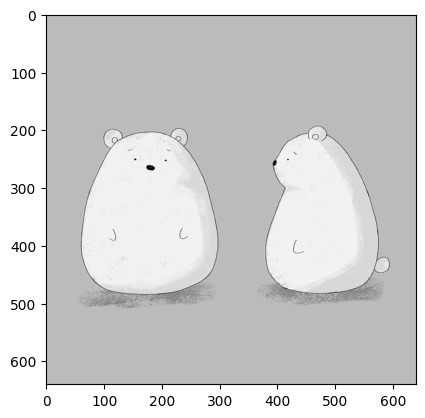

(640, 640)
<class 'numpy.ndarray'>


In [47]:
from PIL import Image
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
image =cv2.imread("input.png",0)
plt.imshow(image,cmap='gray')
plt.show()
print(image.shape)
print(type(image))
# print(image)

(160, 160, 4, 4)
[[187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]]
[[187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]]
[[187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]]


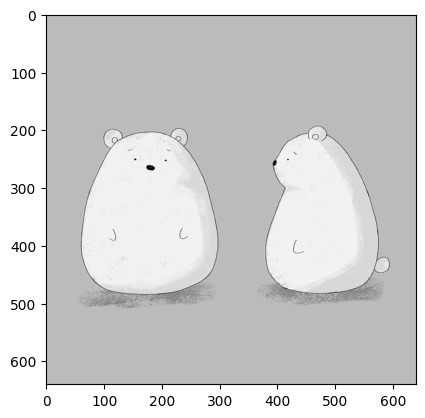

In [48]:
img_strided = image.reshape(image.shape[0]//4, 4, image.shape[1]//4, 4).swapaxes(1, 2)
print(img_strided.shape)
print(img_strided[0][0])
print(img_strided[0][1])
print(img_strided[1][0])
plt.imshow(image,cmap='gray')
plt.show()

In [49]:
#initializations

import hashlib
import random

seed = 1
random.seed(seed)

block_l = img_strided.shape[0]
block_w = img_strided.shape[1]
watermarked_image = np.zeros((block_l*4,block_w*4),dtype=int)
NO_OF_BLOCKS=block_l*block_w
BLOCK_KEYS = ['{0:016b}'.format(x) for x in random.sample(range(0, 2**16), NO_OF_BLOCKS)]
BLOCK_KEYS = np.reshape(BLOCK_KEYS,(block_l,block_w))

print(BLOCK_KEYS.shape)
print(BLOCK_KEYS[0][0])

(160, 160)
0100010011001011


In [50]:
print(BLOCK_KEYS[0,0])

0100010011001011


In [51]:
def strip_lsb(block):
  stripped_block=np.zeros(block.shape,dtype=int)
  for i in range(4):
    for j in range(4):
      stripped_block[i,j] = block[i,j] & 0xfffe
  return stripped_block

def generate_hashcode16(block):
  block_string = "".join([str(x) for x in block.ravel()])
  key = hashlib.sha1(block_string.encode())
  digest = key.hexdigest()
  binary_16_digest = ''.join(format(ord(i), '08b') for i in digest[:2])
  return binary_16_digest
  

b = img_strided[0][0]
print(b)
b = strip_lsb(b)
print(b)
h = generate_hashcode16(b)
print(h)

[[187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]]
[[186 186 186 186]
 [186 186 186 186]
 [186 186 186 186]
 [186 186 186 186]]
0110011001100110


In [52]:
def generate_hash_key_code(block_key,hash_code):
  x = int(block_key, 2)
  y = int(h, 2)
  z = '{0:016b}'.format(x ^ y)
  return z


hkc = generate_hash_key_code(BLOCK_KEYS[0,0],h)
print("Block key:", BLOCK_KEYS[0,0])
print("Hash Key:", h)
print("Hash Key Code:", hkc)

Block key: 0100010011001011
Hash Key: 0110011001100110
Hash Key Code: 0010001010101101


In [53]:
def embed(block, hash_key_code):
  embedded_block = block.copy()
  key_mat = np.reshape([int(x) for x in list(hash_key_code)],(4,4))
  # print(key_mat)
  for i in range(4):
    for j in range(4):
      if key_mat[i,j] == 0:
        embedded_block[i,j] = embedded_block[i,j] & 0xfffe
      else:
        embedded_block[i,j] = embedded_block[i,j] | 0x0001
    
  return embedded_block


final_block =  embed(img_strided[0][0],hkc)
print(img_strided[0][0])
print(final_block)

[[187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]
 [187 187 187 187]]
[[186 186 187 186]
 [186 186 187 186]
 [187 186 187 186]
 [187 187 186 187]]


In [54]:
def get_lsbs(block):
  lsb_array = []
  for i in range(4):
    for j in range(4):
      lsb_array.append(str(block[i,j] & 1))
  return "".join(lsb_array)

#print(get_lsbs(embedded_block[0,0]))

In [55]:
#Block processing

for i in range(block_l):
  for j in range(block_w):
    block = img_strided[i,j]
    #print(block)
    block_key = BLOCK_KEYS[i,j]
    #print(block_key)
    stripped_block = strip_lsb(block)
    #print(stripped_block)
    hash_code = generate_hashcode16(stripped_block)
    #print(hash_code)
    hash_key_code = generate_hash_key_code(block_key,hash_code)
    #print(hash_key_code)
    watermarked_image[i*4:i*4+4,j*4:j*4+4] |= embed(block,hash_key_code)
    #print(watermarked_image[i*4:i*4+4,j*4:j*4+4])

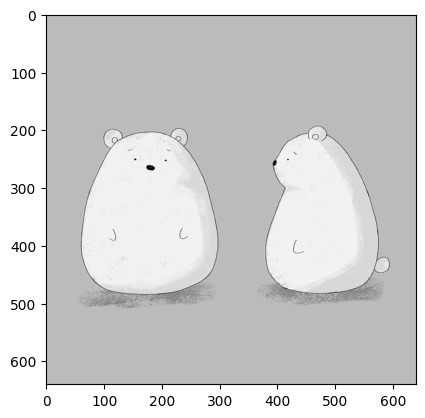

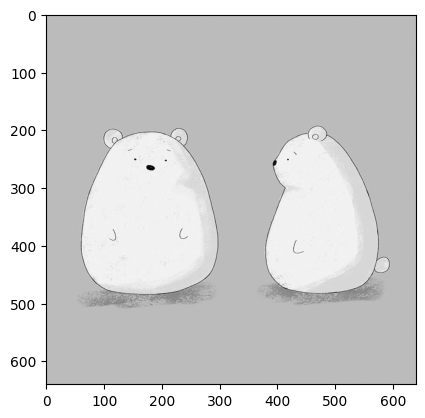

True

In [56]:
from matplotlib import pyplot as plt

plt.imshow(image,cmap='gray')
plt.show()

plt.imshow(watermarked_image,cmap='gray')
plt.show()

cv2.imwrite("watermarked_image.png",watermarked_image)

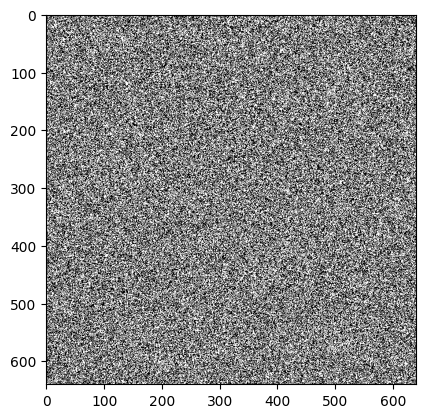

In [57]:
change = np.abs(image-watermarked_image)*255
plt.imshow(change,cmap='gray')
plt.show()

In [58]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

calculate_psnr(image, watermarked_image)

51.142503372712376

In [59]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

ssim(image, watermarked_image)

0.995776027110844